# Imports 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import numpy as np

import yfinance as yf
import datetime as dt
from datetime import date
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, roc_auc_score

from scipy.signal import savgol_filter, argrelmin, argrelmax 

import warnings
warnings.filterwarnings("ignore")

# Bitcoin Dataset from Yahoo Finance

In [2]:
# Here we create the present date as the end date for our yahoo finance end day.
today = date.today().strftime('%Y-%m-%d')
today

'2020-05-06'

In [9]:
# We will grab our data from Yahoo Finance
# We have to set a start date for the first initial data and th end date.
data = yf.Ticker('BTC-USD')
bitcoin = data.history(start='2018-01-01',end=today)

In [10]:
bitcoin.shape

(857, 7)

In [11]:
bitcoin.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-05-02,8869.06,9007.19,8811.37,8988.60,40134388683,0,0
2020-05-03,8983.61,9167.78,8830.97,8897.47,47101785174,0,0
2020-05-04,8895.75,8956.91,8645.02,8912.65,45718796275,0,0
2020-05-05,8912.83,9062.42,8856.83,9003.07,43148462663,0,0
2020-05-06,8999.12,9311.13,8967.10,9225.10,46899965952,0,0


In [12]:
# Dropping 'Dividends' , 'Stock Splits' because they contain NO data.
bitcoin.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

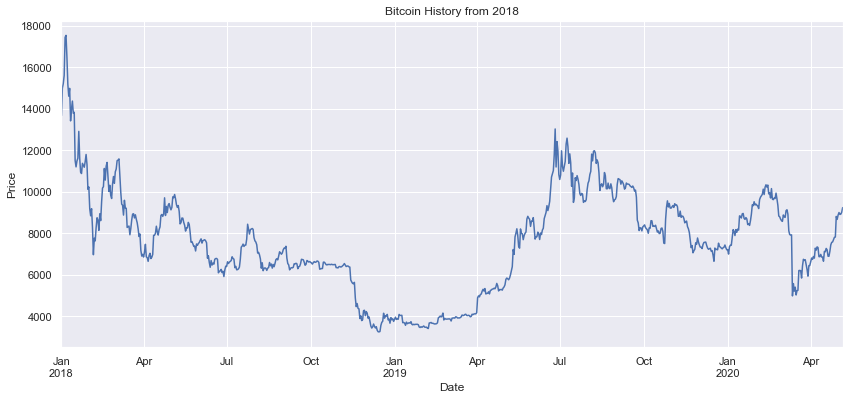

In [14]:
# Lets see our data
plt.figure(figsize=(14,6))
bitcoin.Close.plot()
plt.title('Bitcoin History from 2018')
plt.ylabel('Price');

## Smooth out the data and remove noise

### **savgol_filter**
- will smooth out our data points and make the graph less volitial.

https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.savgol_filter.html

In [15]:
# We create a new columns and start with with a 0 int. 
# savgol_filter will smooth out the data 
# polyorder(int) will be how smooth you want the data. (lower = more smooth)/(high = less smooth)
# Window will be the length we want to filter (must be odd int.)
window = 9
bitcoin['smooth'] = savgol_filter(bitcoin.Close, window, polyorder=6)

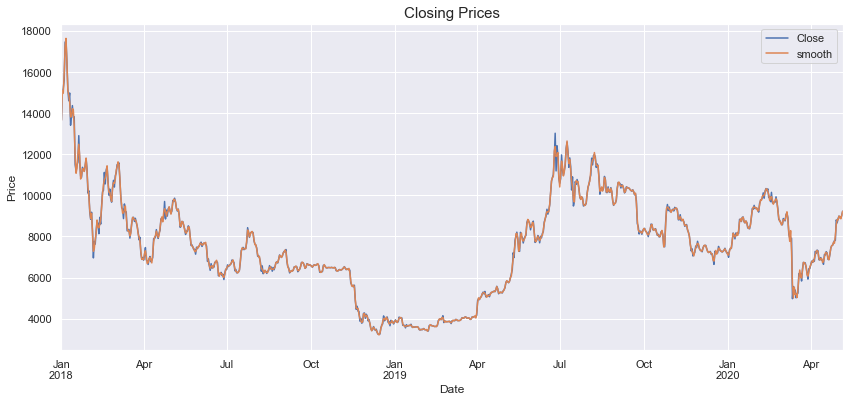

In [16]:
# less sharpness of points and visually less volatile than their original values
plt.figure(figsize=(14,6))
bitcoin.Close.plot()
bitcoin.smooth.plot()
plt.ylabel('Price')
plt.title('Closing Prices', fontsize=15)
plt.legend();

In [17]:
# Here we can see that the smooth column is a bit off compared to the Close column. 
# Smooth column represents Close price, but smoother or a bit less stiff
bitcoin.tail(15)

,Open,High,Low,Close,Volume,smooth
Date,,,,,,
2020-04-22,6879.44,7145.87,6867.78,7117.21,33249153865,7129.038749
2020-04-23,7121.31,7491.79,7081.59,7429.72,43500782316,7420.126138
2020-04-24,7434.18,7574.20,7434.18,7550.90,34636526285,7549.910427
2020-04-25,7550.48,7641.36,7521.67,7569.94,32941541446,7572.285082
2020-04-26,7570.14,7700.59,7561.41,7679.87,33070154490,7717.544794
2020-04-27,7679.42,7795.60,7679.42,7795.60,36162144724,7668.162743
2020-04-28,7796.97,7814.53,7730.81,7807.06,33187959920,8026.687366
2020-04-29,7806.71,8871.75,7786.05,8801.04,60201052202,8563.852315
2020-04-30,8797.67,9440.65,8533.26,8658.55,66964629541,8820.960987


### argrelmin
https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.argrelmin.html
### argrelmax
https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.argrelmax.html#scipy.signal.argrelmax

- argrelmin/max: will find the minima/maxima 
- order is the amount of data points to the left and right. (the amount of adjacent points)

In [18]:
# we will create a new column in the dataframe and set all values to 0
# order: amount of array in which to find the relative minima
# selecting the [0], turns type numpy.ndarray(tuple does not have .tolist meth.). Turn to list type

min_ids = 'min_ids'
max_ids = 'max_ids'
bitcoin[max_ids] = 0
bitcoin[min_ids] = 0

min_id = argrelmin(bitcoin.smooth.values, order=10)[0].tolist()
max_id = argrelmax(bitcoin.smooth.values, order=10)[0].tolist()

# .iloc the min/max and turn them to 1, to indicate if they are low/high price point
# all other data will be 0 if they are not low/high indicators 
bitcoin[min_ids].iloc[min_id] = 1
bitcoin[max_ids].iloc[max_id] = 1

In [19]:
bitcoin.tail()

,Open,High,Low,Close,Volume,smooth,max_ids,min_ids
Date,,,,,,,,
2020-05-02,8869.06,9007.19,8811.37,8988.60,40134388683,8982.565750,0,0
2020-05-03,8983.61,9167.78,8830.97,8897.47,47101785174,8956.232645,0,0
2020-05-04,8895.75,8956.91,8645.02,8912.65,45718796275,8856.301055,0,0
2020-05-05,8912.83,9062.42,8856.83,9003.07,43148462663,9026.874733,0,0
2020-05-06,8999.12,9311.13,8967.10,9225.10,46899965952,9221.161279,0,0


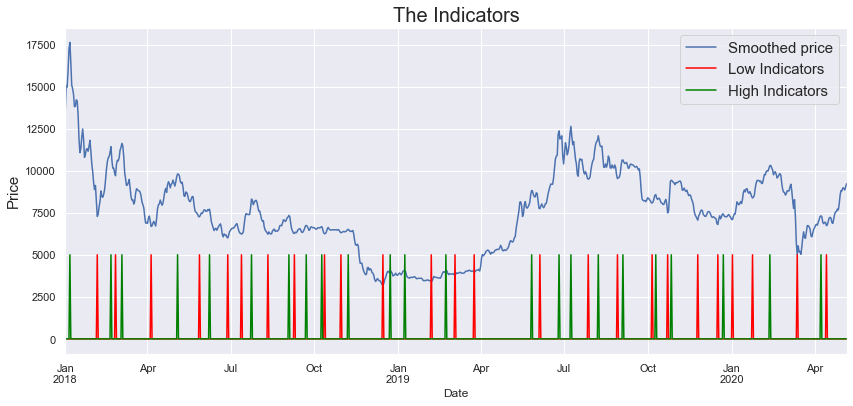

In [20]:
plt.figure(figsize=(14,6))
bitcoin.smooth.plot(label='Smoothed price')
(5000*bitcoin.min_ids).plot(color='red', label='Low Indicators')
(5000*bitcoin.max_ids).plot(color='green', label='High Indicators')
plt.title('The Indicators', fontsize=20)
plt.ylabel('Price', fontsize=15)
plt.legend(fontsize=15);

# Baseline Model
## LogisticRegression Model: target: min_ids (Low Close Price) Best Buy Price

In [21]:
# We created a seperate list for the features dropping ['Open', 'Close', 'Low', 'High', 'min_ids']
# Keeping them may result in multicolinearity.
features_list = bitcoin.drop(columns=['Open', 'High', 'Low', 'Close', 'min_ids']).columns.tolist()

In [22]:
# These are the features we will be using
features_list

['Volume', 'smooth', 'max_ids']

In [23]:
# Lets drop all NaNs and give it a new var. 
# X(features): the clean_bit dataset with the features_list
# y(target): this is our target min_ids (the low closing values)
clean_bit = bitcoin.dropna()
X = clean_bit[features_list]
y = clean_bit['min_ids']

In [24]:
# Lets scale our data so everything is on the same playing field
# We call our LogisticRegression model and give it a var. to call on it later
# We then create a pipe for the scaler and logreg
scaler = preprocessing.StandardScaler().fit(X)
LogReg = LogisticRegression(class_weight='balanced', random_state=42)
pipe = make_pipeline(scaler, LogReg)

# Here we use a roc_auc to score the ability to distinguish the difference between target
scores = cross_val_score(pipe, X, y, n_jobs=-1, cv=5, scoring='roc_auc')
scores.mean(), scores.std()

(0.7453271769713584, 0.06549390144927351)

## target: max_ids (High Close Price) Best Sell Price

In [ ]:
features_list2 = bitcoin.drop(columns=['Open', 'High', 'Low', 'Close', 'max_ids']).columns.tolist()
features_list2

In [ ]:
X = clean_bit[features_list2]
y = clean_bit['max_ids']

scaler = preprocessing.StandardScaler().fit(X)
LogReg = LogisticRegression(class_weight='balanced', random_state=42)
pipe = make_pipeline(scaler, LogReg)

# Here we use a roc_auc to score the ability to distinguish the difference between target
scores = cross_val_score(pipe, X, y, n_jobs=-1, cv=5, scoring='roc_auc')
scores.mean(), scores.std()

### Initial baseline test
- our base model seems to be very unstable just looking at the std(standard deviation)
- our ROC_AUC score for the low and high prediction is very similar.

----------------------------------------------------------------------------------------------------------

# Feature Engineering

- MACD: Moving Average Convergence Divergence
    - Subtracts the 26-period Expoential Moving Average(EMA) from the 12-period (EMA). 
    - https://www.investopedia.com/terms/m/macd.asp
- Std: of rolling (n)windows
    - this will give us a standard deviation of (n)windows from the mean.
- RSI: Relative Strength Index
    - this is a momentum indicator.
    - the standard period is 14(days)
    - calulates the average gain and lose for a period of time
    - values 0 - 100
    - https://www.investopedia.com/terms/r/rsi.asp
- EWM: Exponential Weighted function
    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html

In [25]:
# the window we will use is a 5 and 10 day window
# we will find the avg. of these windows and subtract 
windows = [5, 10]

for w in windows:
    rm = bitcoin.Close.rolling(w).mean()
    bitcoin['MACD_'+str(w)] = rm - bitcoin.Close
    bitcoin['Std_'+str(w)] = bitcoin.Close.rolling(w).std()    
    
    
# the rsi_period will be our standard 14 day window
# Out of the 14 day period. We want to know what are the gains and losses
# 1. we will need to know the diff(1) of two diff. days periodically. 
# 2. we use mask to hide any data that is not a gain 
    # - this will hide the losses and 0 changes.
# 3. this is the same for our loss, hide anything that is not a loss

rsi_period = 14
change = bitcoin.Close.diff(1)
gain = change.mask(change<0,0)
loss = change.mask(change>0,0)

# here we use EWM to find the gain/loss with a period of time
# min_periods: will be our standard 14 day period
# com: is the period that we want to weight in
    # - we want to use the 14 day period, but compare the avg. gain/loss to the original close price
    # - hence why we subtract 1, taking the initial closing price out of the equation since we are
    # using it as a comparison
# we will do this for the gain and loss averages.
avg_gain = gain.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
avg_loss = loss.ewm(com=rsi_period-1, min_periods=rsi_period).mean()

# here we find the absolute value of the relative strength for the gain and loss
rs = abs(avg_gain/avg_loss)

# this is the equation/math for RSI
# we will subtract it from 100 since the scale is 0-100.
rsi = 100 - (100/(1+rs))
bitcoin['RSI'] = rsi

# after finding and creating a new RSI column, we will drop all NANs
bitcoin = bitcoin.dropna()

### Setting up a binary classifier for RSI

In [26]:
# here we create new columns to help us identify if the RSI is >=70 or <=30
# initially we just want the columns to be all 0, we will change this later
# we call upon the new column and .loc the 'RSI' with a bool statement
# if the statement is True then we will identify it as a 1, if not then it will remain a 0

rsi_70 = 'RSI_70'
rsi_30 = 'RSI_30'
bitcoin[rsi_70] = 0
bitcoin[rsi_30] = 0
bitcoin[rsi_70].loc[bitcoin['RSI'] >=70] = 1
bitcoin[rsi_30].loc[bitcoin['RSI'] <=30] = 1

In [27]:
# we can see that our binary classifying worked
bitcoin.tail()

,Open,High,Low,Close,Volume,smooth,max_ids,min_ids,MACD_5,Std_5,MACD_10,Std_10,RSI,RSI_70,RSI_30
Date,,,,,,,,,,,,,,,
2020-05-02,8869.06,9007.19,8811.37,8988.60,40134388683,8982.565750,0,0,-364.596,471.919268,-873.995,629.154402,75.553911,1,0
2020-05-03,8983.61,9167.78,8830.97,8897.47,47101785174,8956.232645,0,0,-55.384,122.900916,-636.090,622.798210,73.065042,1,0
2020-05-04,8895.75,8956.91,8645.02,8912.65,45718796275,8856.301055,0,0,-48.242,123.715082,-515.095,598.593997,73.223275,1,0
2020-05-05,8912.83,9062.42,8856.83,9003.07,43148462663,9026.874733,0,0,-69.758,59.859240,-462.202,547.839051,74.195689,1,0
2020-05-06,8999.12,9311.13,8967.10,9225.10,46899965952,9221.161279,0,0,-219.722,131.155636,-529.709,493.201664,76.456653,1,0


In [28]:
bitcoin.head(20)

,Open,High,Low,Close,Volume,smooth,max_ids,min_ids,MACD_5,Std_5,MACD_10,Std_10,RSI,RSI_70,RSI_30
Date,,,,,,,,,,,,,,,
2018-01-15,13767.30,14445.50,13641.70,13819.80,12750799872,13333.435431,0,0,47.880,346.448830,988.380,1303.213114,44.798209,0,0
2018-01-16,13836.10,13843.10,10194.90,11490.50,18853799936,11871.682906,0,0,1994.120,1138.429177,2714.030,1301.979900,31.936412,0,0
2018-01-17,11431.10,11678.00,9402.29,11188.60,18830600192,11070.617638,0,0,1737.620,1470.607260,2487.030,1349.403135,30.705902,0,0
2018-01-18,11198.80,12107.30,10942.50,11474.90,15020399616,11306.710723,0,0,874.260,1326.252496,1831.210,1399.695246,33.329375,0,0
2018-01-19,11429.80,11992.80,11172.10,11607.40,10740400128,11982.881740,0,0,308.840,1075.223039,1399.910,1412.753560,34.564115,0,0
2018-01-20,11656.20,13103.00,11656.20,12899.20,11801700352,12479.883683,0,0,-1167.080,670.370634,-99.300,1232.848355,45.216664,0,0
2018-01-21,12889.20,12895.90,11288.20,11600.10,9935179776,11890.600544,0,0,153.940,662.237452,1019.230,1266.034297,38.439509,0,0
2018-01-22,11633.10,11966.40,10240.20,10931.40,10537400320,10790.449806,0,0,771.200,724.226757,1383.010,1268.939854,35.490762,0,0
2018-01-23,10944.50,11377.60,10129.70,10868.40,9660609536,10960.577545,0,0,712.900,816.775899,1096.830,1114.465326,35.216666,0,0


## Low Close Predictions + New Features

In [29]:
clean_bit = bitcoin.dropna()
features_list = bitcoin.drop(columns=['Open', 'High', 'Low', 'Close', 'min_ids']).columns.tolist()
X = clean_bit[features_list]
y = clean_bit['min_ids']

In [30]:
# Lets scale our data so everything is on the same playing field
# We call our LogisticRegression model and give it a var. to call on it later
# We then create a pipe for the scaler and logreg
scaler = preprocessing.RobustScaler().fit(X)
LogReg = LogisticRegression(penalty='l2', class_weight='balanced', random_state=42, solver='lbfgs', C=5.0)
pipe = make_pipeline(scaler, LogReg)

# Here we use a roc_auc to score the ability to distinguish the difference between target
scores = cross_val_score(pipe, X, y, n_jobs=-1, cv=5, scoring='roc_auc')
scores.mean(), scores.std()

(0.8516803830614993, 0.04863288399176454)

- After feature engineering, our score has improved a lot from
- our model is better at distinguishing a low close price and it's more stable(but NOT perfect)

In [31]:
# now we're gonna see what the model prediction are
low_preds = cross_val_predict(pipe, X, y, n_jobs=-1, cv=5)

In [32]:
# Lets create a dataframe of our predictions and add it to our original clean_bit dataframe
# We can then use this to plot our prediction points
predict_df = pd.DataFrame()
predict_df['low_preds'] = low_preds.tolist()
clean_bit['low_preds'] = predict_df['low_preds'].values

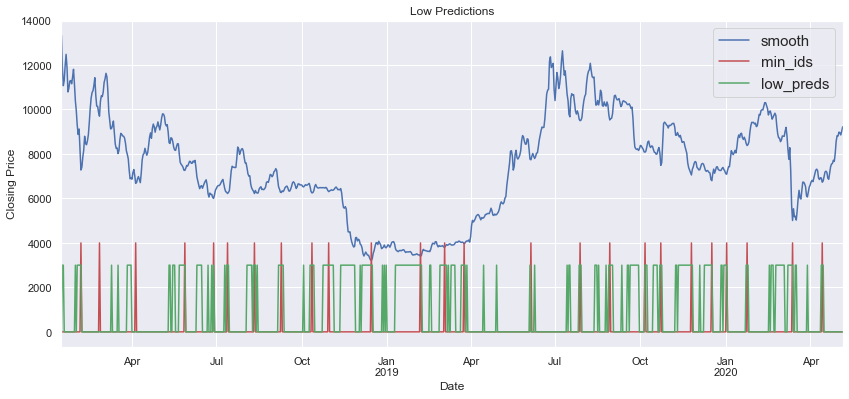

In [33]:
plt.figure(figsize=(14,6))
clean_bit.smooth.plot()
(4000*clean_bit.min_ids).plot(color='r')
(3000*clean_bit.low_preds).plot(color='g')
plt.ylabel('Closing Price')
plt.title('Low Predictions')
plt.legend(fontsize=15);

- In general, we were able to predict the lows 
- Our model also identified other price points as lows

In [34]:
# Lets pull up our dataframe to see which days are the true lows and predicted lows
clean_bit[['Close', 'smooth','min_ids', 'low_preds']].tail(25)

,Close,smooth,min_ids,low_preds
Date,,,,
2020-04-12,6971.09,6931.577584,0,0
2020-04-13,6845.04,6920.267156,0,1
2020-04-14,6842.43,6730.214071,1,1
2020-04-15,6642.11,6784.593450,0,1
2020-04-16,7116.80,6979.672176,0,0
2020-04-17,7096.18,7188.777110,0,0
2020-04-18,7257.67,7226.184794,0,0
2020-04-19,7189.42,7173.201593,0,0
2020-04-20,6881.96,6910.303201,0,0


## High Close Predictions + New Features

In [41]:
# for the high, we're going to switch our the y(target)
clean_bit = bitcoin.dropna()
features_list2 = bitcoin.drop(columns=['Open', 'High', 'Low', 'Close', 'max_ids']).columns.tolist()
X = clean_bit[features_list2]
y = clean_bit['max_ids']

In [42]:
scaler = preprocessing.RobustScaler().fit(X)
LogReg = LogisticRegression(penalty='l2', class_weight='balanced', random_state=42, solver='lbfgs', C=5.0)
pipe = make_pipeline(scaler, LogReg)

# Here we use a roc_auc to score the ability to distinguish the difference between target
scores = cross_val_score(pipe, X, y, n_jobs=-1, cv=5, scoring='roc_auc')
scores.mean(), scores.std()

(0.8334294161123431, 0.06356275852253404)

In [43]:
high_preds = cross_val_predict(pipe, X, y, n_jobs=-1, cv=5)
predict_df['high_preds'] = high_preds.tolist()
clean_bit['high_preds'] = predict_df['high_preds'].values

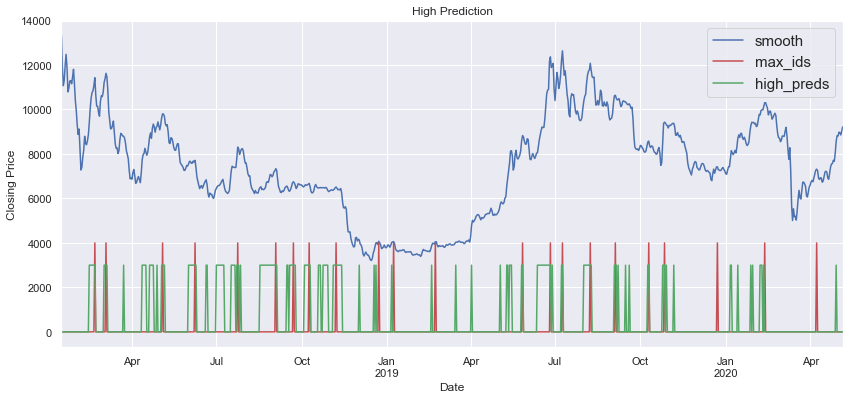

In [44]:
plt.figure(figsize=(14,6))
clean_bit.smooth.plot()
(4000*clean_bit.max_ids).plot(color='r')
(3000*clean_bit.high_preds).plot(color='g')
plt.ylabel('Closing Price')
plt.title('High Prediction')
plt.legend(fontsize=15);

- the model did miss some high points for the true highs
- but it also found some similar highs on the graph

In [45]:
clean_bit[['Close', 'smooth', 'max_ids', 'high_preds']].tail(10)

,Close,smooth,max_ids,high_preds
Date,,,,
2020-04-27,7795.60,7668.162743,0,0
2020-04-28,7807.06,8026.687366,0,0
2020-04-29,8801.04,8563.852315,0,1
2020-04-30,8658.55,8820.960987,0,0
2020-05-01,8864.77,8805.524165,0,0
2020-05-02,8988.60,8982.565750,0,0
2020-05-03,8897.47,8956.232645,0,0
2020-05-04,8912.65,8856.301055,0,0
2020-05-05,9003.07,9026.874733,0,0


### RSI Graph

- 70 or higher: overbought or overvalued
- 30 or less: underbought or undervalued
- This graph can show use the flow of the stock's momentum if the value is too high or too low
- RSI can help us predict the possibility of a drop or a raise.

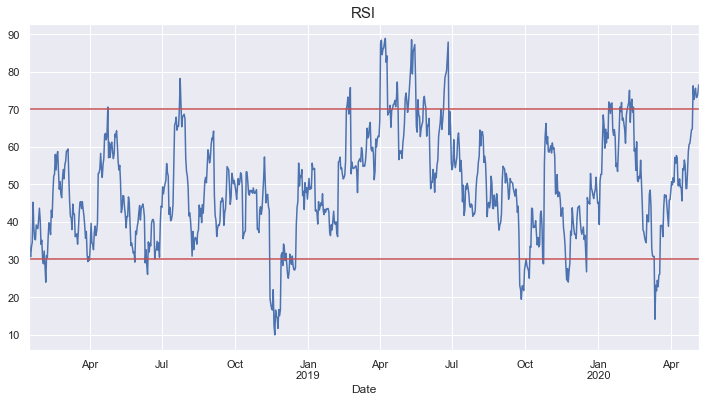

In [46]:
plt.figure(figsize=(12,6))
plt.yticks(np.arange(0,100, step=10))
bitcoin.RSI.plot()
plt.axhline(y=30, color='r')
plt.axhline(y=70, color='r')
plt.title('RSI', fontsize=15);